<a href="https://colab.research.google.com/github/antoniocfetngnu/InteligArtificial1/blob/main/Regresiones/CalderonEAntonio_reg_lineales_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Análisis del DataSet

https://www.kaggle.com/datasets/neuromusic/avocado-prices

Antes de iniciar con los modelos. Realizamos un análisis del DataSet que usaremos en el ejercicio, a continuación, se presenta la información disponible en la fuente:

##CONTENIDO
*La siguiente tabla representa los datos del escaneo minorista semanal de 2018 para el volumen minorista nacional (unidades) y el precio. Los datos de escaneo minorista provienen directamente de las cajas registradoras de los minoristas y se basan en las ventas minoristas reales de aguacates Hass. A partir de 2013, la siguiente tabla refleja un conjunto de datos minoristas ampliado y de múltiples puntos de venta. Los informes de múltiples medios incluyen una agregación de los siguientes canales: comestibles, masas, clubes, drogas, dólares y militares. El precio promedio (de aguacates) en la tabla refleja un costo por unidad (por aguacate), incluso cuando se venden varias unidades (aguacates) en bolsas. Los códigos de búsqueda de productos (PLU) en la tabla son solo para aguacates Hass. Otras variedades de aguacates (por ejemplo, de piel verde) no se incluyen en esta tabla.*

Algunas columnas relevantes en el conjunto de datos:

*   **Date**: la fecha de la observación.
*   **AveragePrice**: el precio medio de un solo aguacate
*   **type**: convencional u orgánico
*   **year** - el año
*   **region**: la ciudad o región de la observación.
*   **Total Volume**: número total de aguacates vendidos
*   **4046** - Número total de aguacates con PLU 4046 vendidos
*   **4225** - Número total de aguacates con PLU 4225 vendidos
*   **4770** - Número total de aguacates con PLU 4770 vendidos



##Importación de Librerías


Una vez familiarizados con el contenido del Dataset, proseguiremos a **limpiar y acomodar la información** antes de realizar las regresiones. Primero importamos todas las librerías necesarias.

In [153]:
# utilizado para manejos de directorios y rutas
import os
#utilizado para importar y ordenar los datos del DATASET
import pandas as pd
# Computacion vectorial y cientifica para python
import numpy as np

# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D
from sklearn.model_selection import train_test_split
# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

Importamos al programa el DataSet **avocado.csv** y verificamos si se importó
correctamente.

In [154]:
df = pd.read_csv('avocado.csv')
print(df.sample(n=200).head(200))

       Unnamed: 0        Date  AveragePrice  Total Volume        4046  \
10148          34  2015-05-03          1.30       2258.10       90.87   
7055            8  2017-11-05          1.32     225563.40   131134.51   
4764           32  2016-05-15          1.10     293520.49    57225.93   
3036           20  2016-08-07          1.48     525387.25    15830.01   
12221          28  2016-06-12          1.57       6617.16        8.36   
...           ...         ...           ...           ...         ...   
16572          29  2017-06-11          1.57       3490.48      261.56   
8014           13  2017-10-01          1.34    4488892.01  2373892.08   
1738           22  2015-07-26          0.77     903242.22   579515.76   
13555          10  2016-10-16          1.44       2930.31      478.48   
14295          22  2016-07-24          1.21     136429.31    53040.76   

            4225      4770  Total Bags  Small Bags  Large Bags  XLarge Bags  \
10148     895.67      0.00     1271.56      

Analizando el DataSet, vemos que tenemos una **CARACTERÍSTICA CÍCLICA (Columna: Date)** además de una columna **year** que indica el mismo año que ya se encuentra en **Date**.
Por tanto, la solución para aprovechar mejor el comportamiento cíclico aplicamos **senos** y **cosenos** a **Date** pero solamente a meses (valor más relevante para tener una variable que indique temporada) y aprovechar la columna **year** para conservar el valor del año. Entonces aplicamos:

http://blog.davidkaleko.com/feature-engineering-cyclical-features.html

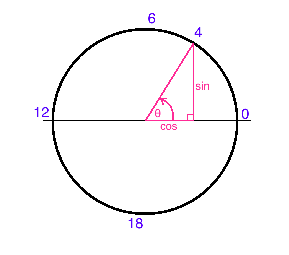

In [155]:
#Nos aseguramos que la columna Date este en el formato correcto DateTime
#Aplicamos la fórmula para volver a Date en 2 nuevos columnas pero
#como características cíclicas.
df['Date'] = pd.to_datetime(df['Date'])
df['month_sin'] = np.sin(2 * np.pi * df['Date'].dt.month / 12)
df['month_cos'] = np.cos(2 * np.pi * df['Date'].dt.month / 12)

# Eliminanos la columna original de fecha ya usaremos las nuevas columas
df.drop('Date', axis=1, inplace=True)

print(df.head(100))

    Unnamed: 0  AveragePrice  Total Volume       4046       4225    4770  \
0            0          1.33      64236.62    1036.74   54454.85   48.16   
1            1          1.35      54876.98     674.28   44638.81   58.33   
2            2          0.93     118220.22     794.70  109149.67  130.50   
3            3          1.08      78992.15    1132.00   71976.41   72.58   
4            4          1.28      51039.60     941.48   43838.39   75.78   
..         ...           ...           ...        ...        ...     ...   
95          43          0.99     512532.44  441544.00   21183.70  347.78   
96          44          1.10     431308.56  369316.29   18324.76  237.47   
97          45          1.06     427391.28  364446.77   17420.41  638.18   
98          46          1.03     433883.91  377256.38   17162.50  524.85   
99          47          0.96     636771.37  553198.56   31583.38  294.94   

    Total Bags  Small Bags  Large Bags  XLarge Bags          type  year  \
0      8696.

Siguiendo con el análisis, vemos que tenemos una característica categórica llamada **region** con valores **no numericos**. Analizando el DataSet observamos que los precios varían dependiendo de la región, por tanto debemos llevarlo a un equivalente numérico.

In [156]:
# Obtenemos los valores únicos de la columna 'region'
regiones_unicas = df['region'].unique()

# Mostrar la lista de valores únicos
print(regiones_unicas)

# Mostrar la cantidad de regiones únicas
print(len(regiones_unicas))

['Albany' 'Atlanta' 'BaltimoreWashington' 'Boise' 'Boston'
 'BuffaloRochester' 'California' 'Charlotte' 'Chicago' 'CincinnatiDayton'
 'Columbus' 'DallasFtWorth' 'Denver' 'Detroit' 'GrandRapids' 'GreatLakes'
 'HarrisburgScranton' 'HartfordSpringfield' 'Houston' 'Indianapolis'
 'Jacksonville' 'LasVegas' 'LosAngeles' 'Louisville' 'MiamiFtLauderdale'
 'Midsouth' 'Nashville' 'NewOrleansMobile' 'NewYork' 'Northeast'
 'NorthernNewEngland' 'Orlando' 'Philadelphia' 'PhoenixTucson'
 'Pittsburgh' 'Plains' 'Portland' 'RaleighGreensboro' 'RichmondNorfolk'
 'Roanoke' 'Sacramento' 'SanDiego' 'SanFrancisco' 'Seattle'
 'SouthCarolina' 'SouthCentral' 'Southeast' 'Spokane' 'StLouis' 'Syracuse'
 'Tampa' 'TotalUS' 'West' 'WestTexNewMexico']
54


Observamos que tenemos 54 regiones (categorías) en total, sin embargo para este ejercicio se decidió generalizar las regiones de EE.UU. en regiones más generales y extensas (para minimizar el número de categorías).

Luego de tener regiones más generales, se les asigna un valor numérico ordinal. Entonces:

In [157]:
# Mapear las regiones a las categorías generalizadas
region_map = {
    'Albany': 'Northeast',
    'Atlanta': 'Southeast',
    'BaltimoreWashington': 'Northeast',
    'Boise': 'West',
    'Boston': 'Northeast',
    'BuffaloRochester': 'Northeast',
    'California': 'West',
    'Charlotte': 'Southeast',
    'Chicago': 'Midwest',
    'CincinnatiDayton': 'Midwest',
    'Columbus': 'Midwest',
    'DallasFtWorth': 'SouthCentral',
    'Denver': 'West',
    'Detroit': 'Midwest',
    'GrandRapids': 'Midwest',
    'GreatLakes': 'Midwest',
    'HarrisburgScranton': 'Northeast',
    'HartfordSpringfield': 'Northeast',
    'Houston': 'SouthCentral',
    'Indianapolis': 'Midwest',
    'Jacksonville': 'Southeast',
    'LasVegas': 'West',
    'LosAngeles': 'West',
    'Louisville': 'Midwest',
    'MiamiFtLauderdale': 'Southeast',
    'Midsouth': 'SouthCentral',
    'Nashville': 'SouthCentral',
    'NewOrleansMobile': 'SouthCentral',
    'NewYork': 'Northeast',
    'Northeast': 'Northeast',
    'NorthernNewEngland': 'Northeast',
    'Orlando': 'Southeast',
    'Philadelphia': 'Northeast',
    'PhoenixTucson': 'West',
    'Pittsburgh': 'Northeast',
    'Plains': 'Midwest',
    'Portland': 'West',
    'RaleighGreensboro': 'Southeast',
    'RichmondNorfolk': 'Southeast',
    'Roanoke': 'Southeast',
    'Sacramento': 'West',
    'SanDiego': 'West',
    'SanFrancisco': 'West',
    'Seattle': 'West',
    'SouthCarolina': 'Southeast',
    'SouthCentral': 'SouthCentral',
    'Southeast': 'Southeast',
    'Spokane': 'West',
    'StLouis': 'Midwest',
    'Syracuse': 'Northeast',
    'Tampa': 'Southeast',
    'TotalUS': 'TotalUS',
    'West': 'West',
    'WestTexNewMexico': 'West'
}

# Aplicar el mapeo a la columna 'region'
df['region'] = df['region'].map(region_map)
#A Las categorías se les asignará un valor ordinal siendo TotalUS el valor
#ordinal más elevado.
region_ordinal_map = {
    'Northeast': 1,
    'Midwest': 2,
    'SouthCentral': 3,
    'Southeast': 4,
    'West': 5,
    'TotalUS': 6
}

# Aplicar el mapeo a la columna 'region'
df['region_ordinal'] = df['region'].map(region_ordinal_map)

print(df.sample(n=20).head(20))


       Unnamed: 0  AveragePrice  Total Volume       4046       4225  \
6030           43          1.41     202553.07   43409.71   87666.41   
4931           43          1.13     439280.11  133683.82  213422.76   
7293           34          1.17     529138.31  340439.27   66961.88   
1708           44          1.36     348215.37   14876.71  214953.17   
5266           14          1.05      74748.35   17028.27   21111.25   
9559           17          1.60      30663.55    1065.92   29017.63   
511            43          0.89     226951.64    3610.46  157400.74   
13833          28          1.67      25140.30    6921.86   15536.84   
5003           11          1.82     673082.26  163264.54  409307.88   
4591           15          1.33      80206.95   22513.05   30643.05   
6063           23          1.59     752799.06   79551.49  459858.58   
8264           51          1.43      67353.38    1221.37   41382.49   
10400          26          1.86       1627.96    1181.34       9.95   
17560 

Ahora, terminada la conversión de datos de Region, realizaremos un análisis de correlación de variables.

In [158]:
correlation_matrix = df.corr()

# Imprime la matriz de correlación
print(correlation_matrix)

                Unnamed: 0  AveragePrice  Total Volume      4046      4225  \
Unnamed: 0        1.000000     -0.133008      0.014035  0.017628  0.019829   
AveragePrice     -0.133008      1.000000     -0.192752 -0.208317 -0.172928   
Total Volume      0.014035     -0.192752      1.000000  0.977863  0.974181   
4046              0.017628     -0.208317      0.977863  1.000000  0.926110   
4225              0.019829     -0.172928      0.974181  0.926110  1.000000   
4770              0.041752     -0.179446      0.872202  0.833389  0.887855   
Total Bags       -0.002219     -0.177088      0.963047  0.920057  0.905787   
Small Bags        0.000347     -0.174730      0.967238  0.925280  0.916031   
Large Bags       -0.009196     -0.172940      0.880640  0.838645  0.810015   
XLarge Bags      -0.011546     -0.117592      0.747157  0.699377  0.688809   
year             -0.171667      0.093197      0.017193  0.003353 -0.009559   
month_sin         0.583604     -0.221891      0.022639  0.023467

<ipython-input-158-0d3fc10aa1f1>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


De acuerdo a los resultado, podemos observar que tenemos gran grado de correlacion (80%-94%) entre el tamaño de las Bolsas, y esto es **correcto** ya que la columna **Total Bags** es la suma de **Small Bags **, **Large Bags** y **XLarge Bags**. Por tanto para no caer en redundancia y problemas en nuestros modelos, utilizaremos solamente la columna **Total Bags** y eliminaremos las otras 3 columnas (ya que no es un dato muy relevante en el precio (label Y).

Además, de la misma forma, **Total Volume** tiene un grado de correlacion elevado (97%) con los PLU de los aguacates, y es de la misma forma **correcto**, ya que en la información del DataSet nos indica que Total Volume es la cantidad total de paltas vendidas, y los **PLU 4046 ,4225 y 4770** son el total de paltas vendidas de esa clasificación (tipo de palta), sin embargo en este caso eliminaremos la columna **Total Volume** ya que puede ser **relevante el tipo de palta **para predecir el precio.

Entonces eliminando las columnas que ya no necesitamos, obtendremos:

In [159]:
df.drop('Unnamed: 0', axis=1, inplace=True) #numeración de datos
df.drop('Total Volume', axis=1, inplace=True)
df.drop('Small Bags', axis=1, inplace=True)
df.drop('Large Bags', axis=1, inplace=True)
df.drop('XLarge Bags', axis=1, inplace=True)
print(df.head())

   AveragePrice     4046       4225    4770  Total Bags          type  year  \
0          1.33  1036.74   54454.85   48.16     8696.87  conventional  2015   
1          1.35   674.28   44638.81   58.33     9505.56  conventional  2015   
2          0.93   794.70  109149.67  130.50     8145.35  conventional  2015   
3          1.08  1132.00   71976.41   72.58     5811.16  conventional  2015   
4          1.28   941.48   43838.39   75.78     6183.95  conventional  2015   

      region     month_sin  month_cos  region_ordinal  
0  Northeast -2.449294e-16   1.000000               1  
1  Northeast -2.449294e-16   1.000000               1  
2  Northeast -2.449294e-16   1.000000               1  
3  Northeast -2.449294e-16   1.000000               1  
4  Northeast -5.000000e-01   0.866025               1  


Y para finalizar con la limpieza y ordenado de datos, vemos la característica type, que indica el tipo de aguacates en 2 categorías (conventional y organic), por tanto debemos analizar cómo afecta a nuestra Salida dicha variable para asignar un valor ordinal, tal como hicimos con región. Entonces:

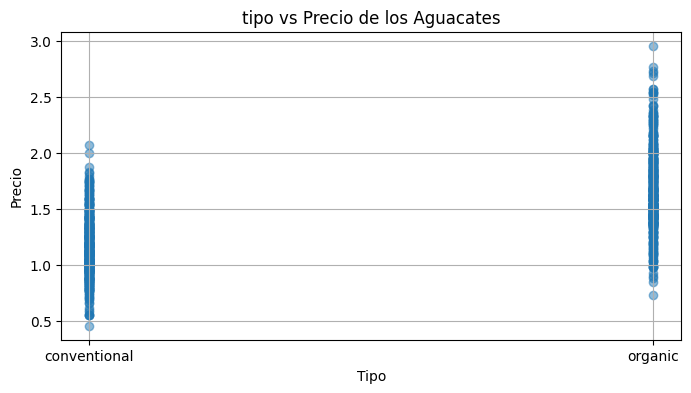

In [160]:
muestraRegion = df.sample(n=1000)
pyplot.figure(figsize=(8, 4))
pyplot.scatter(muestraRegion['type'], muestraRegion['AveragePrice'], alpha=0.5)
pyplot.title('tipo vs Precio de los Aguacates')
pyplot.xlabel('Tipo')
pyplot.ylabel('Precio')
pyplot.grid(True)
pyplot.show()

Gracias a la gráfica podemos observar que los aguacates orgánicos son generalmente más caros que los convencionales y esto tiene sentido ya que los orgánicos se los cultiva en menor cantidad y con más cuidados para no usar químicos en su siembra.

Por tanto:
Para convertirlos en valor numérico usaremos el orden:
0.conventional
1.organic

In [161]:
#transformar a ordinal columna  type
df['type'] = df['type'].map({'conventional': 0, 'organic': 1})
print(df.head())

   AveragePrice     4046       4225    4770  Total Bags  type  year  \
0          1.33  1036.74   54454.85   48.16     8696.87     0  2015   
1          1.35   674.28   44638.81   58.33     9505.56     0  2015   
2          0.93   794.70  109149.67  130.50     8145.35     0  2015   
3          1.08  1132.00   71976.41   72.58     5811.16     0  2015   
4          1.28   941.48   43838.39   75.78     6183.95     0  2015   

      region     month_sin  month_cos  region_ordinal  
0  Northeast -2.449294e-16   1.000000               1  
1  Northeast -2.449294e-16   1.000000               1  
2  Northeast -2.449294e-16   1.000000               1  
3  Northeast -2.449294e-16   1.000000               1  
4  Northeast -5.000000e-01   0.866025               1  


In [162]:
#OJO, observamos que no eliminamos la columna region
#debemos hacerlo ya que tenemos su equivalente en ordinal que calculamos anteriormente
df.drop('region', axis=1, inplace=True)
print(df.head())

   AveragePrice     4046       4225    4770  Total Bags  type  year  \
0          1.33  1036.74   54454.85   48.16     8696.87     0  2015   
1          1.35   674.28   44638.81   58.33     9505.56     0  2015   
2          0.93   794.70  109149.67  130.50     8145.35     0  2015   
3          1.08  1132.00   71976.41   72.58     5811.16     0  2015   
4          1.28   941.48   43838.39   75.78     6183.95     0  2015   

      month_sin  month_cos  region_ordinal  
0 -2.449294e-16   1.000000               1  
1 -2.449294e-16   1.000000               1  
2 -2.449294e-16   1.000000               1  
3 -2.449294e-16   1.000000               1  
4 -5.000000e-01   0.866025               1  


## Conclusión Análisis

Queda concluido el análisis y organización de los datos del DataSet, los resultados finales son:


*   Características Totales: 9



#2 Modelos
Para los modelos primero separaremos los datos en entrenamiento y prueba, antes de aplicarlos.


In [163]:
print(df.head())


   AveragePrice     4046       4225    4770  Total Bags  type  year  \
0          1.33  1036.74   54454.85   48.16     8696.87     0  2015   
1          1.35   674.28   44638.81   58.33     9505.56     0  2015   
2          0.93   794.70  109149.67  130.50     8145.35     0  2015   
3          1.08  1132.00   71976.41   72.58     5811.16     0  2015   
4          1.28   941.48   43838.39   75.78     6183.95     0  2015   

      month_sin  month_cos  region_ordinal  
0 -2.449294e-16   1.000000               1  
1 -2.449294e-16   1.000000               1  
2 -2.449294e-16   1.000000               1  
3 -2.449294e-16   1.000000               1  
4 -5.000000e-01   0.866025               1  


Separamos las características del label (Y)

In [164]:
y = df['AveragePrice']
X = df.drop(columns=['AveragePrice'])



In [165]:
print(X.head(10))
print("---------------")
print(y.head(10))

      4046       4225    4770  Total Bags  type  year     month_sin  \
0  1036.74   54454.85   48.16     8696.87     0  2015 -2.449294e-16   
1   674.28   44638.81   58.33     9505.56     0  2015 -2.449294e-16   
2   794.70  109149.67  130.50     8145.35     0  2015 -2.449294e-16   
3  1132.00   71976.41   72.58     5811.16     0  2015 -2.449294e-16   
4   941.48   43838.39   75.78     6183.95     0  2015 -5.000000e-01   
5  1184.27   48067.99   43.61     6683.91     0  2015 -5.000000e-01   
6  1368.92   73672.72   93.26     8318.86     0  2015 -5.000000e-01   
7   703.75  101815.36   80.00     6829.22     0  2015 -5.000000e-01   
8  1022.15   87315.57   85.34    11388.36     0  2015 -5.000000e-01   
9   842.40   64757.44  113.00     8625.92     0  2015 -8.660254e-01   

   month_cos  region_ordinal  
0   1.000000               1  
1   1.000000               1  
2   1.000000               1  
3   1.000000               1  
4   0.866025               1  
5   0.866025               1  
6

In [166]:
# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [167]:
print('X_train(LENGHT):',len(X_train))
print('y_train(LENGHT):',len(y_train))
print('X_test(LENGHT):',len(X_test))
print('y_test(LENGHT):',len(y_test))

print('------------')
print(X_train.head())
print('------------')
print(y_train.head())

X_train(LENGHT): 14599
y_train(LENGHT): 14599
X_test(LENGHT): 3650
y_test(LENGHT): 3650
------------
            4046       4225      4770  Total Bags  type  year     month_sin  \
16391     147.41     871.40      0.00     4357.77     1  2017 -5.000000e-01   
4990   155537.61  153030.46  21523.37   248519.50     0  2016  5.000000e-01   
13653    2026.07    2529.20      0.00     1914.81     1  2016 -5.000000e-01   
2074    78195.76   38763.75    134.25    28554.64     0  2015  8.660254e-01   
12377     162.25   38677.24      0.00     1695.56     1  2016  1.224647e-16   

       month_cos  region_ordinal  
16391   0.866025               4  
4990    0.866025               5  
13653   0.866025               5  
2074    0.500000               4  
12377  -1.000000               2  
------------
16391    1.88
4990     0.81
13653    2.01
2074     1.02
12377    1.53
Name: AveragePrice, dtype: float64


In [168]:
print(X_test.head())
print('------------')
print(y_test.head())

            4046      4225     4770  Total Bags  type  year  month_sin  \
8604    79239.58  26356.05  2998.74   109735.33     0  2018   0.866025   
2608   228324.13  72749.38   100.62    90340.30     0  2015  -0.500000   
14581    1147.09     39.51     0.00     2720.80     1  2016   0.500000   
4254   150786.30  27025.48   565.65    89576.35     0  2016   1.000000   
16588     828.39      3.24     0.00     7973.65     1  2017   0.866025   

          month_cos  region_ordinal  
8604   5.000000e-01               2  
2608   8.660254e-01               4  
14581  8.660254e-01               4  
4254   6.123234e-17               3  
16588  5.000000e-01               1  
------------
8604     0.82
2608     0.97
14581    1.44
4254     0.97
16588    1.45
Name: AveragePrice, dtype: float64


##2.1 Regresion Lineal Multivariable

Primero debemos normalizar nuestros datos.
Sin embargo, debemos convertir el DataFrame de pandas en un array de NumPy sin encabezados ni índices, entonces:

In [169]:
X_tr = X_train.values

In [170]:
y_tr= y_train.values

In [171]:
m=y_tr.size
n = X_tr.shape[0]
print(m,n)

14599 14599


In [172]:
# imprimir algunos puntos de datos
print('{:>8s}{:>8s}{:>10s}'.format('X[:,0]', 'X[:, 1]', 'y'))
print('-'*26)
for i in range(10):
    print('{:8.0f}{:8.0f}{:10.0f}'.format(X_tr[i, 0], X_tr[i, 1], y_tr[i]))

  X[:,0] X[:, 1]         y
--------------------------
     147     871         2
  155538  153030         1
    2026    2529         2
   78196   38764         1
     162   38677         2
  126893   33866         1
     487    1465         2
  145444   50581         1
    2680  129292         1
    6195  112907         1


Vemos que con la función anterior los valores se redondean así que para comprobación imprimimos los ahora convertidos a vectores.

In [173]:
print(X_tr[:10])

[[ 1.47410000e+02  8.71400000e+02  0.00000000e+00  4.35777000e+03
   1.00000000e+00  2.01700000e+03 -5.00000000e-01  8.66025404e-01
   4.00000000e+00]
 [ 1.55537610e+05  1.53030460e+05  2.15233700e+04  2.48519500e+05
   0.00000000e+00  2.01600000e+03  5.00000000e-01  8.66025404e-01
   5.00000000e+00]
 [ 2.02607000e+03  2.52920000e+03  0.00000000e+00  1.91481000e+03
   1.00000000e+00  2.01600000e+03 -5.00000000e-01  8.66025404e-01
   5.00000000e+00]
 [ 7.81957600e+04  3.87637500e+04  1.34250000e+02  2.85546400e+04
   0.00000000e+00  2.01500000e+03  8.66025404e-01  5.00000000e-01
   4.00000000e+00]
 [ 1.62250000e+02  3.86772400e+04  0.00000000e+00  1.69556000e+03
   1.00000000e+00  2.01600000e+03  1.22464680e-16 -1.00000000e+00
   2.00000000e+00]
 [ 1.26893080e+05  3.38659000e+04  2.80582000e+03  1.12857070e+05
   0.00000000e+00  2.01700000e+03  5.00000000e-01 -8.66025404e-01
   2.00000000e+00]
 [ 4.86970000e+02  1.46540000e+03  0.00000000e+00  4.52290000e+02
   1.00000000e+00  2.0150000

In [174]:
print(y_tr[:10])

[1.88 0.81 2.01 1.02 1.53 0.93 1.67 1.05 0.88 0.96]


Ahora, una vez acomodados y verificados los datos en arrays de Numpy, normalizamos para que todas las características se encuentren en un mismo rango de valores, usaremos la media y la desviación estandar:

In [175]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [176]:
# llama featureNormalize con los datos cargados
X_norm, mu, sigma = featureNormalize(X_tr)

print(X_tr)
print('Media calculada:', mu)
print('Desviación estandar calculada:', sigma)
print(X_norm)

[[ 1.47410000e+02  8.71400000e+02  0.00000000e+00 ... -5.00000000e-01
   8.66025404e-01  4.00000000e+00]
 [ 1.55537610e+05  1.53030460e+05  2.15233700e+04 ...  5.00000000e-01
   8.66025404e-01  5.00000000e+00]
 [ 2.02607000e+03  2.52920000e+03  0.00000000e+00 ... -5.00000000e-01
   8.66025404e-01  5.00000000e+00]
 ...
 [ 9.92240000e+02  5.49504800e+04  7.69070000e+02 ...  5.00000000e-01
  -8.66025404e-01  1.00000000e+00]
 [ 4.27661600e+04  1.40403760e+05  2.02831000e+03 ...  1.22464680e-16
  -1.00000000e+00  1.00000000e+00]
 [ 5.68010000e+02  1.41033000e+03  0.00000000e+00 ...  8.66025404e-01
   5.00000000e-01  2.00000000e+00]]
Media calculada: [2.93423606e+05 2.94394353e+05 2.27792595e+04 2.38037614e+05
 4.99554764e-01 2.01614878e+03 5.30890749e-02 3.11009144e-02
 3.14870882e+00]
Desviación estandar calculada: [1.24307532e+06 1.19552256e+06 1.07620880e+05 9.67020791e+05
 4.99999802e-01 9.40334388e-01 7.09275944e-01 7.02240642e-01
 1.56853945e+00]
[[-0.23592794 -0.24551854 -0.21166208 

Para realizar correctamente la multiplicación matricial entre caracteristicas y parametros thita, entonces debemos aumentar el elemento de sesgo (1.0) como la primera columna de las filas de la matriz X_tr

In [177]:
# Añade el termino de interseccion a X
# (Columna de unos para X0)
X_tr = np.concatenate([np.ones((m, 1)), X_norm], axis=1)

In [178]:
print(X_tr[:10])

[[ 1.         -0.23592794 -0.24551854 -0.21166208 -0.24164924  1.00089087
   0.90523403 -0.77979393  1.18894356  0.54272858]
 [ 1.         -0.11092328 -0.11824444 -0.01166957  0.01083936 -0.99910992
  -0.15821745  0.63009458  1.18894356  1.18026435]
 [ 1.         -0.23441664 -0.24413186 -0.21166208 -0.24417552  1.00089087
  -0.15821745 -0.77979393  1.18894356  1.18026435]
 [ 1.         -0.17314144 -0.21382332 -0.21041465 -0.21662717 -0.99910992
  -1.22166894  1.14614959  0.66771853  0.54272858]
 [ 1.         -0.235916   -0.21389568 -0.21166208 -0.24440225  1.00089087
  -0.15821745 -0.07484968 -1.4683014  -0.73234296]
 [ 1.         -0.13396656 -0.21792015 -0.18559075 -0.12944969 -0.99910992
   0.90523403  0.63009458 -1.27751979 -0.73234296]
 [ 1.         -0.23565478 -0.24502168 -0.21166208 -0.24568792  1.00089087
  -1.22166894 -1.48473818 -0.04428812 -0.73234296]
 [ 1.         -0.11904335 -0.20393887 -0.21082758 -0.14189963 -0.99910992
  -0.15821745  1.14614959  0.66771853  0.54272858]


##Descenso por el Gradiente

Ahora utilizaremos el método de resolucióñ de Descenso por el Gradiente, mediante la función de costo y el error  cuadrático medio se irán ajustando los valores de thitha para que vaya reduciendo en cada iteracion el costo.



In [179]:
def computeCostMulti(X_tr, y_tr, theta):
    # Inicializa algunos valores utiles
    m = y_tr.shape[0] # numero de ejemplos de entrenamiento

    J = 0

    h = np.dot(X_tr, theta)

    J = (1/(2 * m)) * np.sum(np.square(np.dot(X_tr, theta) - y_tr))

    return J

In [180]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):

    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()

    J_history = []

    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_history.append(computeCostMulti(X, y, theta))

    return theta, J_history

Una vez declaradas las funciones, ahora procedemos con las iteraciones.

theta calculado por el descenso por el gradiente: [ 1.40479646e+00 -4.91699379e-02  4.59138653e-02 -9.09933848e-03
 -1.40157500e-05  2.47093596e-01  5.28871796e-02 -9.55913351e-02
 -2.27326136e-02 -4.27197067e-02]


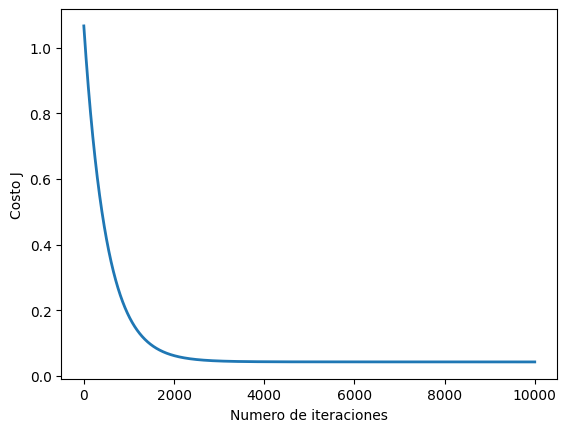

In [181]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.001 # alpha = 0.003
num_iters = 10000

# inicializa theta y ejecuta el descenso por el gradiente
theta = np.zeros(10)
theta, J_history = gradientDescentMulti(X_tr, y_tr, theta, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(theta)))

###Predicciones
Obtenidos los valores del vector thitha (desde thitha0 hasta thitha9)
Ahora se hará predicciones con los valores que reservamos para testeo.

In [182]:
X_tst = X_test.values
y_tst= y_test.values


Utilizaremos 10 valores de testeo solamente ya que es la asignación pedida en el ejercicio (minimamente)

In [183]:
print(X_tst[:10])
print('-----------------')
print(y_tst[:10])

[[ 7.92395800e+04  2.63560500e+04  2.99874000e+03  1.09735330e+05
   0.00000000e+00  2.01800000e+03  8.66025404e-01  5.00000000e-01
   2.00000000e+00]
 [ 2.28324130e+05  7.27493800e+04  1.00620000e+02  9.03403000e+04
   0.00000000e+00  2.01500000e+03 -5.00000000e-01  8.66025404e-01
   4.00000000e+00]
 [ 1.14709000e+03  3.95100000e+01  0.00000000e+00  2.72080000e+03
   1.00000000e+00  2.01600000e+03  5.00000000e-01  8.66025404e-01
   4.00000000e+00]
 [ 1.50786300e+05  2.70254800e+04  5.65650000e+02  8.95763500e+04
   0.00000000e+00  2.01600000e+03  1.00000000e+00  6.12323400e-17
   3.00000000e+00]
 [ 8.28390000e+02  3.24000000e+00  0.00000000e+00  7.97365000e+03
   1.00000000e+00  2.01700000e+03  8.66025404e-01  5.00000000e-01
   1.00000000e+00]
 [ 1.77820000e+02  2.57421000e+03  2.12430000e+02  2.54597000e+03
   1.00000000e+00  2.01600000e+03  8.66025404e-01  5.00000000e-01
   4.00000000e+00]
 [ 1.14942210e+05  2.49231140e+05  9.40890000e+02  7.28658920e+05
   1.00000000e+00  2.0170000

In [184]:
X_tst1=X_tst[0:10].copy()
y_tst1=y_tst[0:10].copy()
print(X_tst1)
print(y_tst1)

[[ 7.92395800e+04  2.63560500e+04  2.99874000e+03  1.09735330e+05
   0.00000000e+00  2.01800000e+03  8.66025404e-01  5.00000000e-01
   2.00000000e+00]
 [ 2.28324130e+05  7.27493800e+04  1.00620000e+02  9.03403000e+04
   0.00000000e+00  2.01500000e+03 -5.00000000e-01  8.66025404e-01
   4.00000000e+00]
 [ 1.14709000e+03  3.95100000e+01  0.00000000e+00  2.72080000e+03
   1.00000000e+00  2.01600000e+03  5.00000000e-01  8.66025404e-01
   4.00000000e+00]
 [ 1.50786300e+05  2.70254800e+04  5.65650000e+02  8.95763500e+04
   0.00000000e+00  2.01600000e+03  1.00000000e+00  6.12323400e-17
   3.00000000e+00]
 [ 8.28390000e+02  3.24000000e+00  0.00000000e+00  7.97365000e+03
   1.00000000e+00  2.01700000e+03  8.66025404e-01  5.00000000e-01
   1.00000000e+00]
 [ 1.77820000e+02  2.57421000e+03  2.12430000e+02  2.54597000e+03
   1.00000000e+00  2.01600000e+03  8.66025404e-01  5.00000000e-01
   4.00000000e+00]
 [ 1.14942210e+05  2.49231140e+05  9.40890000e+02  7.28658920e+05
   1.00000000e+00  2.0170000

Como nuestros valores están normalizados (el modelo) también debemos normalizar los valores de prueba, por tanto, añadimos el sesgo y luego restamos la media y dividimos entre las desviación estandar(excluyendo al sesgo)

In [185]:

X_tst1Sesgo = np.concatenate([np.ones((y_tst1.shape[0], 1)), X_tst1], axis=1)
print(X_tst1Sesgo)

[[ 1.00000000e+00  7.92395800e+04  2.63560500e+04  2.99874000e+03
   1.09735330e+05  0.00000000e+00  2.01800000e+03  8.66025404e-01
   5.00000000e-01  2.00000000e+00]
 [ 1.00000000e+00  2.28324130e+05  7.27493800e+04  1.00620000e+02
   9.03403000e+04  0.00000000e+00  2.01500000e+03 -5.00000000e-01
   8.66025404e-01  4.00000000e+00]
 [ 1.00000000e+00  1.14709000e+03  3.95100000e+01  0.00000000e+00
   2.72080000e+03  1.00000000e+00  2.01600000e+03  5.00000000e-01
   8.66025404e-01  4.00000000e+00]
 [ 1.00000000e+00  1.50786300e+05  2.70254800e+04  5.65650000e+02
   8.95763500e+04  0.00000000e+00  2.01600000e+03  1.00000000e+00
   6.12323400e-17  3.00000000e+00]
 [ 1.00000000e+00  8.28390000e+02  3.24000000e+00  0.00000000e+00
   7.97365000e+03  1.00000000e+00  2.01700000e+03  8.66025404e-01
   5.00000000e-01  1.00000000e+00]
 [ 1.00000000e+00  1.77820000e+02  2.57421000e+03  2.12430000e+02
   2.54597000e+03  1.00000000e+00  2.01600000e+03  8.66025404e-01
   5.00000000e-01  4.00000000e+00

In [186]:
for i in range(len(X_tst1Sesgo)):
    X_tst1Sesgo[i, 1:] = (X_tst1Sesgo[i, 1:] - mu) / sigma
# for row in X_tst1Sesgo:

# X_tst1Sesgo[1:10] = (X_tst1[1:10] - mu) / sigma
print(X_tst1Sesgo)

[[ 1.         -0.17230173 -0.22420179 -0.18379816 -0.1326779  -0.99910992
   1.96868551  1.14614959  0.66771853 -0.73234296]
 [ 1.         -0.0523697  -0.18539589 -0.21072713 -0.15273437 -0.99910992
  -1.22166894 -0.77979393  1.18894356  0.54272858]
 [ 1.         -0.23512374 -0.24621438 -0.21166208 -0.24334204  1.00089087
  -0.15821745  0.63009458  1.18894356  0.54272858]
 [ 1.         -0.11474551 -0.22364185 -0.20640613 -0.15352438 -0.99910992
  -0.15821745  1.33503883 -0.04428812 -0.09480719]
 [ 1.         -0.23538012 -0.24624471 -0.21166208 -0.23791005  1.00089087
   0.90523403  1.14614959  0.66771853 -1.36987873]
 [ 1.         -0.23590347 -0.24409422 -0.20968821 -0.24352283  1.00089087
  -0.15821745  1.14614959  0.66771853  0.54272858]
 [ 1.         -0.14358052 -0.03777696 -0.20291945  0.50735342  1.00089087
   0.90523403 -1.48473818 -0.04428812  1.81780012]
 [ 1.          7.82124894  9.7943423  12.56708935  9.48465486 -0.99910992
  -0.15821745  1.14614959  0.66771853  1.81780012]


Realizamos la multiplicación matricial con las thethas encontrads y obtenemos las y predichas y las comparamos con las y de testeo.


In [187]:
priceL = np.dot(X_tst1Sesgo, theta)

In [188]:
print(priceL)
print('-----------')
print(y_tst1)

[1.16843794 1.1136231  1.53548369 1.02424798 1.63596222 1.49811983
 1.77242914 0.89779893 1.7929127  1.26468901]
-----------
[0.82 0.97 1.44 0.97 1.45 1.29 2.03 0.94 2.45 1.83]


##2.2 Ecuacion de la Normal
En este método es todo más directo, solo debemos aumentar el sesgo a la matriz de características para realizar correctamente las multiplicaciones matriciales.


Guardamos en otra variable nuestros valores de X y Y de entrenamiento.

In [189]:
X_trN = X_train.values
y_trN = y_train.values

In [190]:
mN=y_trN.size
nN = X_trN.shape[0]
print(mN,nN)

14599 14599


In [191]:
# imprimir algunos puntos de datos
print('{:>8s}{:>8s}{:>10s}'.format('X[:,0]', 'X[:, 1]', 'y'))
print('-'*26)
for i in range(10):
    print('{:8.0f}{:8.0f}{:10.0f}'.format(X_trN[i, 0], X_trN[i, 1], y_trN[i]))

  X[:,0] X[:, 1]         y
--------------------------
     147     871         2
  155538  153030         1
    2026    2529         2
   78196   38764         1
     162   38677         2
  126893   33866         1
     487    1465         2
  145444   50581         1
    2680  129292         1
    6195  112907         1


In [192]:
X_trN = np.concatenate([np.ones((mN, 1)), X_trN], axis=1)

In [193]:
print(X_trN[:10])

[[ 1.00000000e+00  1.47410000e+02  8.71400000e+02  0.00000000e+00
   4.35777000e+03  1.00000000e+00  2.01700000e+03 -5.00000000e-01
   8.66025404e-01  4.00000000e+00]
 [ 1.00000000e+00  1.55537610e+05  1.53030460e+05  2.15233700e+04
   2.48519500e+05  0.00000000e+00  2.01600000e+03  5.00000000e-01
   8.66025404e-01  5.00000000e+00]
 [ 1.00000000e+00  2.02607000e+03  2.52920000e+03  0.00000000e+00
   1.91481000e+03  1.00000000e+00  2.01600000e+03 -5.00000000e-01
   8.66025404e-01  5.00000000e+00]
 [ 1.00000000e+00  7.81957600e+04  3.87637500e+04  1.34250000e+02
   2.85546400e+04  0.00000000e+00  2.01500000e+03  8.66025404e-01
   5.00000000e-01  4.00000000e+00]
 [ 1.00000000e+00  1.62250000e+02  3.86772400e+04  0.00000000e+00
   1.69556000e+03  1.00000000e+00  2.01600000e+03  1.22464680e-16
  -1.00000000e+00  2.00000000e+00]
 [ 1.00000000e+00  1.26893080e+05  3.38659000e+04  2.80582000e+03
   1.12857070e+05  0.00000000e+00  2.01700000e+03  5.00000000e-01
  -8.66025404e-01  2.00000000e+00

In [194]:
def normalEqn(X, y):

    thetaN = np.zeros(X.shape[1])

    thetaN = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),y)

    return thetaN

Una vez definida la ecuación de la normal, simplemente la aplicamos y guardamos los valores thetha (en thenaN) para luego realizar predicciones.

In [195]:
# Calcula los parametros con la ecuación de la normal
thetaN = normalEqn(X_trN, y_trN);

# Muestra los resultados optenidos a partir de la aplicación de la ecuación de la normal
print('Theta calculado a partir de la ecuación de la normal: {:s}'.format(str(thetaN)));


Theta calculado a partir de la ecuación de la normal: [-1.12580454e+02 -7.30773634e-08  8.57015656e-08 -2.34705369e-07
 -1.08185489e-09  4.94194329e-01  5.64571100e-02 -1.33982711e-01
 -3.37583137e-02 -2.46187864e-02]


###Predicciones
Se hara predicciones con los valores reservados para testeo.

In [196]:
X_tst2=X_tst[0:10].copy()
y_tst2=y_tst[0:10].copy()
print(X_tst2)
print(y_tst2)

[[ 7.92395800e+04  2.63560500e+04  2.99874000e+03  1.09735330e+05
   0.00000000e+00  2.01800000e+03  8.66025404e-01  5.00000000e-01
   2.00000000e+00]
 [ 2.28324130e+05  7.27493800e+04  1.00620000e+02  9.03403000e+04
   0.00000000e+00  2.01500000e+03 -5.00000000e-01  8.66025404e-01
   4.00000000e+00]
 [ 1.14709000e+03  3.95100000e+01  0.00000000e+00  2.72080000e+03
   1.00000000e+00  2.01600000e+03  5.00000000e-01  8.66025404e-01
   4.00000000e+00]
 [ 1.50786300e+05  2.70254800e+04  5.65650000e+02  8.95763500e+04
   0.00000000e+00  2.01600000e+03  1.00000000e+00  6.12323400e-17
   3.00000000e+00]
 [ 8.28390000e+02  3.24000000e+00  0.00000000e+00  7.97365000e+03
   1.00000000e+00  2.01700000e+03  8.66025404e-01  5.00000000e-01
   1.00000000e+00]
 [ 1.77820000e+02  2.57421000e+03  2.12430000e+02  2.54597000e+03
   1.00000000e+00  2.01600000e+03  8.66025404e-01  5.00000000e-01
   4.00000000e+00]
 [ 1.14942210e+05  2.49231140e+05  9.40890000e+02  7.28658920e+05
   1.00000000e+00  2.0170000

Añadimos el sesgo y tenemos:

In [197]:

X_tst2Sesgo = np.concatenate([np.ones((y_tst2.shape[0], 1)), X_tst2], axis=1)
print(X_tst2Sesgo)

[[ 1.00000000e+00  7.92395800e+04  2.63560500e+04  2.99874000e+03
   1.09735330e+05  0.00000000e+00  2.01800000e+03  8.66025404e-01
   5.00000000e-01  2.00000000e+00]
 [ 1.00000000e+00  2.28324130e+05  7.27493800e+04  1.00620000e+02
   9.03403000e+04  0.00000000e+00  2.01500000e+03 -5.00000000e-01
   8.66025404e-01  4.00000000e+00]
 [ 1.00000000e+00  1.14709000e+03  3.95100000e+01  0.00000000e+00
   2.72080000e+03  1.00000000e+00  2.01600000e+03  5.00000000e-01
   8.66025404e-01  4.00000000e+00]
 [ 1.00000000e+00  1.50786300e+05  2.70254800e+04  5.65650000e+02
   8.95763500e+04  0.00000000e+00  2.01600000e+03  1.00000000e+00
   6.12323400e-17  3.00000000e+00]
 [ 1.00000000e+00  8.28390000e+02  3.24000000e+00  0.00000000e+00
   7.97365000e+03  1.00000000e+00  2.01700000e+03  8.66025404e-01
   5.00000000e-01  1.00000000e+00]
 [ 1.00000000e+00  1.77820000e+02  2.57421000e+03  2.12430000e+02
   2.54597000e+03  1.00000000e+00  2.01600000e+03  8.66025404e-01
   5.00000000e-01  4.00000000e+00

In [198]:
price1N = np.dot(X_tst2Sesgo, thetaN)

De la misma forma que en el anterior método, comparamos valores predichos y de testeo.

In [199]:
print(price1N)
print('-----------')
print(y_tst2)

[1.16349073 1.10933168 1.53648897 1.0203084  1.63013226 1.50004268
 1.7859522  0.92030482 1.79767127 1.26670334]
-----------
[0.82 0.97 1.44 0.97 1.45 1.29 2.03 0.94 2.45 1.83]


##2.3 Regresion polinomial

En este método, la hipotesis aumenta la cantidad de elementos enormemente dependiendo de dos puntos:

1.   Cantidad de características
2.   Grado del polinomio

En este caso se hara una hipótesis de grado 2. Pero como tenemos 9 características, todas las combinaciones que debemos realizar son:
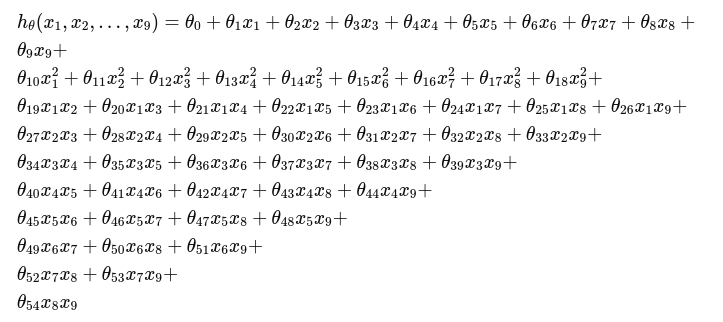



Llegando a un total de 55 características, contando el sesgo. En el procedimiento se realiza la concatenacion de 3 matrices para poder llegar a la hipótesis de la imagen anterior.

1.   La matriz de las características simples
2.   La matriz de las características al cuadrado (2do grado)
3.   La matriz de las combinaciones de todas las características.



In [200]:
X_trP = X_train.values

In [201]:
y_trP= y_train.values

In [202]:
mP=y_trP.size
nP = X_trP.shape[0]
print(mP,nP)

14599 14599


In [203]:
# imprimir algunos puntos de datos
print('{:>8s}{:>8s}{:>10s}'.format('X[:,0]', 'X[:, 1]', 'y'))
print('-'*26)
for i in range(10):
    print('{:8.0f}{:8.0f}{:10.0f}'.format(X_trP[i, 0], X_trP[i, 1], y_trP[i]))

  X[:,0] X[:, 1]         y
--------------------------
     147     871         2
  155538  153030         1
    2026    2529         2
   78196   38764         1
     162   38677         2
  126893   33866         1
     487    1465         2
  145444   50581         1
    2680  129292         1
    6195  112907         1


In [204]:
print(X_trP[:10])

[[ 1.47410000e+02  8.71400000e+02  0.00000000e+00  4.35777000e+03
   1.00000000e+00  2.01700000e+03 -5.00000000e-01  8.66025404e-01
   4.00000000e+00]
 [ 1.55537610e+05  1.53030460e+05  2.15233700e+04  2.48519500e+05
   0.00000000e+00  2.01600000e+03  5.00000000e-01  8.66025404e-01
   5.00000000e+00]
 [ 2.02607000e+03  2.52920000e+03  0.00000000e+00  1.91481000e+03
   1.00000000e+00  2.01600000e+03 -5.00000000e-01  8.66025404e-01
   5.00000000e+00]
 [ 7.81957600e+04  3.87637500e+04  1.34250000e+02  2.85546400e+04
   0.00000000e+00  2.01500000e+03  8.66025404e-01  5.00000000e-01
   4.00000000e+00]
 [ 1.62250000e+02  3.86772400e+04  0.00000000e+00  1.69556000e+03
   1.00000000e+00  2.01600000e+03  1.22464680e-16 -1.00000000e+00
   2.00000000e+00]
 [ 1.26893080e+05  3.38659000e+04  2.80582000e+03  1.12857070e+05
   0.00000000e+00  2.01700000e+03  5.00000000e-01 -8.66025404e-01
   2.00000000e+00]
 [ 4.86970000e+02  1.46540000e+03  0.00000000e+00  4.52290000e+02
   1.00000000e+00  2.0150000

In [205]:
print(y_trP[:10])

[1.88 0.81 2.01 1.02 1.53 0.93 1.67 1.05 0.88 0.96]


Una vez nuevamente verificados los datos del dataset, empezamos con el procedimiento mencionado, primero obtenemos los cuadrados.

In [206]:
X_trPSquare=X_trP**2

In [207]:
print(X_trPSquare[:10])

[[2.17297081e+04 7.59337960e+05 0.00000000e+00 1.89901594e+07
  1.00000000e+00 4.06828900e+06 2.50000000e-01 7.50000000e-01
  1.60000000e+01]
 [2.41919481e+10 2.34183217e+10 4.63255456e+08 6.17619419e+10
  0.00000000e+00 4.06425600e+06 2.50000000e-01 7.50000000e-01
  2.50000000e+01]
 [4.10495964e+06 6.39685264e+06 0.00000000e+00 3.66649734e+06
  1.00000000e+00 4.06425600e+06 2.50000000e-01 7.50000000e-01
  2.50000000e+01]
 [6.11457688e+09 1.50262831e+09 1.80230625e+04 8.15367466e+08
  0.00000000e+00 4.06022500e+06 7.50000000e-01 2.50000000e-01
  1.60000000e+01]
 [2.63250625e+04 1.49592889e+09 0.00000000e+00 2.87492371e+06
  1.00000000e+00 4.06425600e+06 1.49975978e-32 1.00000000e+00
  4.00000000e+00]
 [1.61018538e+10 1.14689918e+09 7.87262587e+06 1.27367182e+10
  0.00000000e+00 4.06828900e+06 2.50000000e-01 7.50000000e-01
  4.00000000e+00]
 [2.37139781e+05 2.14739716e+06 0.00000000e+00 2.04566244e+05
  1.00000000e+00 4.06022500e+06 1.00000000e+00 3.37445951e-32
  4.00000000e+00]
 [2.11

Una vez obtenidos los cuadrados, ahora obtenemos las combinaciones simples de todas las características

In [208]:
def row_multiplications(row):
    n = len(row)
    result = [row[i] * row[j] for i in range(n) for j in range(i+1, n)]
    return result

# Aplicar la función a cada fila de la matriz original
X_trPCombined = np.array([row_multiplications(row) for row in X_trP])


In [209]:
print(X_trPCombined[:10])

[[ 1.28453074e+05  0.00000000e+00  6.42378876e+05  1.47410000e+02
   2.97325970e+05 -7.37050000e+01  1.27660805e+02  5.89640000e+02
   0.00000000e+00  3.79736078e+06  8.71400000e+02  1.75761380e+06
  -4.35700000e+02  7.54654537e+02  3.48560000e+03  0.00000000e+00
   0.00000000e+00  0.00000000e+00 -0.00000000e+00  0.00000000e+00
   0.00000000e+00  4.35777000e+03  8.78962209e+06 -2.17888500e+03
   3.77393952e+03  1.74310800e+04  2.01700000e+03 -5.00000000e-01
   8.66025404e-01  4.00000000e+00 -1.00850000e+03  1.74677324e+03
   8.06800000e+03 -4.33012702e-01 -2.00000000e+00  3.46410162e+00]
 [ 2.38019920e+10  3.34769353e+09  3.86541291e+10  0.00000000e+00
   3.13563822e+08  7.77688050e+04  1.34699522e+05  7.77688050e+05
   3.29373121e+09  3.80310534e+10  0.00000000e+00  3.08509407e+08
   7.65152300e+04  1.32528266e+05  7.65152300e+05  5.34897715e+09
   0.00000000e+00  4.33911139e+07  1.07616850e+04  1.86397852e+04
   1.07616850e+05  0.00000000e+00  5.01015312e+08  1.24259750e+05
   2.1522

Obtenemos resultados satisfactorios, ya que la cantidad de elementos de cada fila coinciden con la cantidad de elementos de la hipótesis, por tanto, procedemos a concatenar las 3 matrices.

In [210]:

X_trPFull = np.concatenate([X_trP, X_trPSquare,X_trPCombined], axis=1)


In [211]:
print(X_trPFull[:10])

[[ 1.47410000e+02  8.71400000e+02  0.00000000e+00  4.35777000e+03
   1.00000000e+00  2.01700000e+03 -5.00000000e-01  8.66025404e-01
   4.00000000e+00  2.17297081e+04  7.59337960e+05  0.00000000e+00
   1.89901594e+07  1.00000000e+00  4.06828900e+06  2.50000000e-01
   7.50000000e-01  1.60000000e+01  1.28453074e+05  0.00000000e+00
   6.42378876e+05  1.47410000e+02  2.97325970e+05 -7.37050000e+01
   1.27660805e+02  5.89640000e+02  0.00000000e+00  3.79736078e+06
   8.71400000e+02  1.75761380e+06 -4.35700000e+02  7.54654537e+02
   3.48560000e+03  0.00000000e+00  0.00000000e+00  0.00000000e+00
  -0.00000000e+00  0.00000000e+00  0.00000000e+00  4.35777000e+03
   8.78962209e+06 -2.17888500e+03  3.77393952e+03  1.74310800e+04
   2.01700000e+03 -5.00000000e-01  8.66025404e-01  4.00000000e+00
  -1.00850000e+03  1.74677324e+03  8.06800000e+03 -4.33012702e-01
  -2.00000000e+00  3.46410162e+00]
 [ 1.55537610e+05  1.53030460e+05  2.15233700e+04  2.48519500e+05
   0.00000000e+00  2.01600000e+03  5.0000

Ahora, una vez acomodados los datos en arrays de Numpy, normalizamos, pero en este caso como se observa en la matriz, tenemos 54 características, primero normalizaremos y luego agregamos el sesgo como siempro lo hacemos:

In [212]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma

In [213]:
# llama featureNormalize con los datos cargados
X_normP, muP, sigmaP = featureNormalize(X_trPFull)

print(X_trPFull)
print('Media calculada:', muP)
print('Desviación estandar calculada:', sigmaP)
print(X_normP)

[[ 1.47410000e+02  8.71400000e+02  0.00000000e+00 ... -4.33012702e-01
  -2.00000000e+00  3.46410162e+00]
 [ 1.55537610e+05  1.53030460e+05  2.15233700e+04 ...  4.33012702e-01
   2.50000000e+00  4.33012702e+00]
 [ 2.02607000e+03  2.52920000e+03  0.00000000e+00 ... -4.33012702e-01
  -2.50000000e+00  4.33012702e+00]
 ...
 [ 9.92240000e+02  5.49504800e+04  7.69070000e+02 ... -4.33012702e-01
   5.00000000e-01 -8.66025404e-01]
 [ 4.27661600e+04  1.40403760e+05  2.02831000e+03 ... -1.22464680e-16
   1.22464680e-16 -1.00000000e+00]
 [ 5.68010000e+02  1.41033000e+03  0.00000000e+00 ...  4.33012702e-01
   1.73205081e+00  1.00000000e+00]]
Media calculada: [ 2.93423606e+05  2.94394353e+05  2.27792595e+04  2.38037614e+05
  4.99554764e-01  2.01614878e+03  5.30890749e-02  3.11009144e-02
  3.14870882e+00  1.63133366e+12  1.51594223e+12  1.21011484e+10
  9.91791115e+11  4.99554764e-01  4.06485678e+06  5.05890814e-01
  4.94109186e-01  1.23746832e+01  1.45805821e+12  1.17410296e+11
  1.17637835e+12  3.71

In [214]:
# Añade el termino de interseccion a X
# (Columna de unos para X0)
X_trPFull = np.concatenate([np.ones((mP, 1)), X_normP], axis=1)

In [215]:
print(X_trPFull[:5])

[[ 1.         -0.23592794 -0.24551854 -0.21166208 -0.24164924  1.00089087
   0.90523403 -0.77979393  1.18894356  0.54272858 -0.11093978 -0.10667262
  -0.08712288 -0.09776285  1.00089087  0.90514644 -0.730557    0.730557
   0.36738842 -0.10448311 -0.09757822 -0.1037036  -0.20443021 -0.23592852
  -0.03710576  0.005423   -0.19249517 -0.09359534 -0.10376991 -0.20641453
  -0.24552596 -0.03216571 -0.00763511 -0.17558709 -0.09494532 -0.1655518
  -0.21167217 -0.04400426  0.01117796 -0.16299434 -0.13691148 -0.24162646
  -0.04223154 -0.00301247 -0.18378529  1.00172962 -1.04993114  1.71903619
   1.2593579  -0.78015242  1.18944074  0.54380293 -1.26166301 -0.86818265
   1.36366162]
 [ 1.         -0.11092328 -0.11824444 -0.01166957  0.01083936 -0.99910992
  -0.15821745  0.63009458  1.18894356  1.18026435 -0.1092946  -0.10502479
  -0.08378765 -0.0916766  -0.99910992 -0.15843686 -0.730557    0.730557
   1.27944546 -0.10277749 -0.094796   -0.1002961  -0.21286651 -0.11093263
   0.0503014   0.15250689 -0

##Descenso por el Gradiente


In [216]:
def computeCostMulti(X_tr, y_tr, theta):
    # Inicializa algunos valores utiles
    m = y_tr.shape[0] # numero de ejemplos de entrenamiento

    J = 0

    h = np.dot(X_tr, theta)

    J = (1/(2 * m)) * np.sum(np.square(np.dot(X_tr, theta) - y_tr))

    return J

In [217]:
def gradientDescentMulti(X, y, theta, alpha, num_iters):

    # Inicializa algunos valores
    m = y.shape[0] # numero de ejemplos de entrenamiento

    # realiza una copia de theta, el cual será acutalizada por el descenso por el gradiente
    theta = theta.copy()

    J_history = []

    for i in range(num_iters):
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        J_history.append(computeCostMulti(X, y, theta))

    return theta, J_history

Una vez declaradas las funciones, ahora procedemos con las iteraciones.

theta calculado por el descenso por el gradiente: [ 1.40479646e+00 -4.15975132e-02  1.86833351e-02 -7.61567677e-03
 -1.06168461e-02  6.30467925e-02  2.90707913e-02 -1.01494111e-02
 -1.34079159e-02 -5.75274486e-02  1.55616867e-02  3.58481943e-03
 -1.23687893e-02  1.01620579e-02  6.30467925e-02  2.90989973e-02
  1.35759823e-02 -1.35759823e-02  5.72386302e-02  1.23605181e-02
  5.79169307e-03  1.20745052e-02 -3.27815521e-02 -4.15841669e-02
  1.19576100e-02  3.94022554e-03 -7.47585897e-03 -3.53067984e-03
  8.31305358e-03  3.71791702e-02  1.87129801e-02  1.22985502e-02
 -8.64683366e-03  1.86429210e-02  3.98257624e-04  6.18783165e-03
 -7.59497029e-03 -3.81502413e-03 -2.89356902e-05  6.01029585e-03
 -3.89433028e-02 -1.05980754e-02 -1.53610994e-02 -1.12655819e-04
  1.09293944e-03  6.29372923e-02 -1.41647957e-02 -4.56977253e-03
  7.04191090e-02 -1.03613063e-02 -1.34751209e-02 -5.74051327e-02
 -2.47035018e-02 -7.49113367e-02  1.11600856e-02]


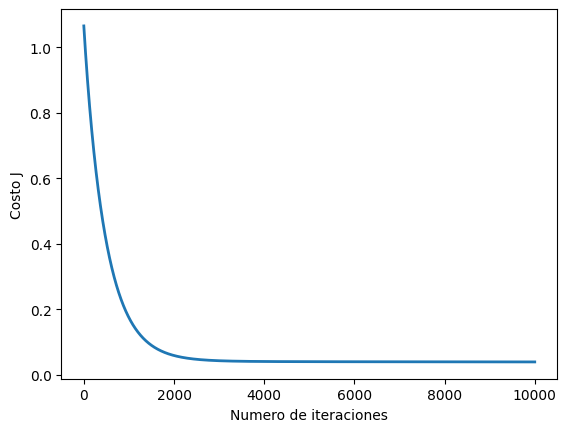

In [218]:
# Elegir algun valor para alpha (probar varias alternativas)
alpha = 0.001 # alpha = 0.003
num_iters = 10000

# inicializa theta y ejecuta el descenso por el gradiente
thetaP = np.zeros(55)
thetaP, J_historyP = gradientDescentMulti(X_trPFull, y_trP, thetaP, alpha, num_iters)

# Grafica la convergencia del costo
pyplot.plot(np.arange(len(J_historyP)), J_historyP, lw=2)
pyplot.xlabel('Numero de iteraciones')
pyplot.ylabel('Costo J')

# Muestra los resultados del descenso por el gradiente
print('theta calculado por el descenso por el gradiente: {:s}'.format(str(thetaP)))

###Predicciones
Para realizar predicciones al igual que en metodos anteriores, utilizamos los valores thetha obtenidos.

Sin embargo, la diferencia radica en que un ejemplo(tupla) también debemos llevarlo a la forma de nuestra hipótesis polinomial (55 características).

Por tanto, como se pidio por lo menos 10 evaluaciones (predicciones) tenemos:

In [219]:
X_tstP=X_test.values

In [220]:
Y_tstP=y_test.values

In [221]:
X_tst1P=X_tstP[0:10].copy()
y_tst1P=Y_tstP[0:10].copy()

una vez separadas 10 predicciones, debemos obtener los cuadrados y las combinaciones de todas las X (*el mismo caso y los mismos pasos que en el entrenamiento*):

In [222]:
X_tstPSquare=X_tstP**2
def row_multiplications(row):
    n = len(row)
    result = [row[i] * row[j] for i in range(n) for j in range(i+1, n)]
    return result

# Aplicar la función a cada fila de la matriz original
X_tstPCombined = np.array([row_multiplications(row) for row in X_tstP])
print(X_tstPCombined[:10])

[[ 2.08844233e+09  2.37618898e+08  8.69538146e+09  0.00000000e+00
   1.59905472e+08  6.86234893e+04  3.96197900e+04  1.58479160e+05
   7.90349414e+07  2.89218984e+09  0.00000000e+00  5.31865089e+07
   2.28250088e+04  1.31780250e+04  5.27121000e+04  3.29067723e+08
   0.00000000e+00  6.05145732e+06  2.59698502e+03  1.49937000e+03
   5.99748000e+03  0.00000000e+00  2.21445896e+08  9.50335835e+04
   5.48676650e+04  2.19470660e+05  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  1.74763926e+03  1.00900000e+03
   4.03600000e+03  4.33012702e-01  1.73205081e+00  1.00000000e+00]
 [ 1.66104389e+10  2.29739740e+07  2.06268704e+10  0.00000000e+00
   4.60073122e+08 -1.14162065e+05  1.97734497e+05  9.13296520e+05
   7.32004262e+06  6.57220081e+09  0.00000000e+00  1.46590001e+08
  -3.63746900e+04  6.30028112e+04  2.90997520e+05  9.09004099e+06
   0.00000000e+00  2.02749300e+05 -5.03100000e+01  8.71394761e+01
   4.02480000e+02  0.00000000e+00  1.82035704e+08 -4.51701500e+04
   7.8236

Unimos las X, X al cuadrado y las combinaciones de todas las X (en el mismo orden que en el entrenamiento y thithas):

In [223]:
X_tstPFull = np.concatenate([X_tstP, X_tstPSquare,X_tstPCombined], axis=1)

Normalizamos la matriz completa con todos los valores

In [224]:
def  featureNormalize(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma

    return X_norm, mu, sigma
# llama featureNormalize con los datos cargados
X_tnormP, mutP, sigmatP = featureNormalize(X_tstPFull)

print(X_tstPFull)
print('Media calculada:', mutP)
print('Desviación estandar calculada:', sigmatP)
print(X_tnormP)

[[ 7.92395800e+04  2.63560500e+04  2.99874000e+03 ...  4.33012702e-01
   1.73205081e+00  1.00000000e+00]
 [ 2.28324130e+05  7.27493800e+04  1.00620000e+02 ... -4.33012702e-01
  -2.00000000e+00  3.46410162e+00]
 [ 1.14709000e+03  3.95100000e+01  0.00000000e+00 ...  4.33012702e-01
   2.00000000e+00  3.46410162e+00]
 ...
 [ 8.68817820e+05  2.52752290e+05  1.20476700e+04 ...  4.33012702e-01
   2.50000000e+00  4.33012702e+00]
 [ 1.43100000e+01  3.70780000e+02  0.00000000e+00 ... -1.22464680e-16
   1.22464680e-16 -1.00000000e+00]
 [ 7.85639000e+03  1.95451000e+04  2.33029000e+03 ...  4.33012702e-01
  -5.00000000e-01 -8.66025404e-01]]
Media calculada: [ 2.91347811e+05  2.98195223e+05  2.30816255e+04  2.46045117e+05
  5.01369863e-01  2.01614438e+03  6.08257762e-02  4.15205429e-02
  3.14438356e+00  1.90446851e+12  1.62093886e+12  1.19431486e+10
  1.18306364e+12  5.01369863e-01  4.06483906e+06  5.13835616e-01
  4.86164384e-01  1.23427397e+01  1.65303337e+12  1.30246461e+11
  1.38449014e+12  3.39

Añadimos el sesgo(bias):

In [225]:
X_tstPFullS = np.concatenate([np.ones((mP, 1)), X_normP], axis=1)
print(X_tstPFullS)

[[ 1.         -0.23592794 -0.24551854 ... -1.26166301 -0.86818265
   1.36366162]
 [ 1.         -0.11092328 -0.11824444 ...  1.16844693  0.93566844
   1.71386309]
 [ 1.         -0.23441664 -0.24413186 ... -1.26166301 -1.06861055
   1.71386309]
 ...
 [ 1.         -0.23524831 -0.20028386 ... -1.26166301  0.13395684
  -0.38734571]
 [ 1.         -0.20164301 -0.12880609 ... -0.04660804 -0.06647106
  -0.44152206]
 [ 1.         -0.23558958 -0.24506775 ...  1.16844693  0.62783155
   0.36723358]]


Finalmente hacemos la multiplicación con las thitas para obtener las Y predichas y comparamos resultados:

In [227]:
pricePol = np.dot(X_tstPFullS, thetaP)
print(pricePol[:10])
print('-----------')
print(Y_tstP[:10])

[1.79007814 0.94553603 1.762508   0.91716236 1.70367976 1.25206945
 1.75498924 0.97276199 1.17885899 1.33928331]
-----------
[0.82 0.97 1.44 0.97 1.45 1.29 2.03 0.94 2.45 1.83]


Como se puede observar, las 10 predicciones (sin contar la primera) estan mucho mas cercanas que las predicciones en la regresión lineal o con la ecuación de la normal, l oque nos indicaría la caracteristica o presencia de curvas (no rectas) que representan a este Dataset de avocados. Con esto se concluye los requerimientos para el laboratorio 1.